# DAY 1 : LLMs

## Calling OCI models

### Supported models (https://docs.oracle.com/en-us/iaas/Content/generative-ai/chat-models.htm) 
- cohere.command-r-08-2024
- cohere.command-r-16k
- cohere.command-r-plus
- cohere.command-r-plus-08-2024
- meta.llama-3.1-405b-instruct
- meta.llama-3.1-70b-instruct
- meta.llama-3.2-90b-vision-instruct

Questions use #generative-ai-users  or ##igiu-innovation-lab slack channels 
if you have errors running sample code reach out for help in #igiu-ai-learning

In [1]:
# set up the  variables


from oci.generative_ai_inference import GenerativeAiInferenceClient
from oci.generative_ai_inference.models import *
import oci
import json, os 

#####
#make sure your sandbox.json file is setup for your environment. You might have to specify the full path depending on  your `cwd` 
# you can also try making your cwd ofr jupyter match your workspace python code: 
# vscopde menu -> Settings > Extensions > Jupyter > Notebook File Root
# change from ${fileDirname} to ${workspaceFolder}
#####

#SANDBOX_CONFIG_FILE = "~/work/code/python/workshop/sandbox.json"
SANDBOX_CONFIG_FILE = "sandbox.json"

LLM_MODEL = "cohere.command-r-plus-08-2024" 
PREAMBLE = """
        answer in three bullets. respond in hindi 
"""
MESSAGE = """
        "why is indian cricket team so good"
"""

llm_service_endpoint= "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com"

In [2]:
scfg = None
# read the sandbox config 
with open(os.path.expanduser(SANDBOX_CONFIG_FILE), 'r') as f:
                scfg=  json.load(f)

#read the oci config
config = oci.config.from_file(os.path.expanduser(scfg["oci"]["configFile"]),scfg["oci"]["profile"])
                              
# chat request      
llm_chat_request = CohereChatRequest()
llm_chat_request.preamble_override = PREAMBLE 
llm_chat_request.message = MESSAGE
llm_chat_request.is_stream = False 
llm_chat_request.max_tokens = 500 # max token to generate, can lead to incomplete responses
llm_chat_request.temperature = 1.0 # higer value menas more randon, defaul = 0.3
llm_chat_request.top_p = 0.7  # ensures only tokens with toptal probabely of p are considered, max value = 0.99, min 0.01, default 0.75
llm_chat_request.top_k = 0  #Ensures that only top k tokens are considered, 0 turns it off, max = 500
llm_chat_request.frequency_penalty = 0.0 # reduces the repeatedness of tokens max value 1.9=0, min 0,0



# set up chat details
chat_detail = ChatDetails()
chat_detail.serving_mode = OnDemandServingMode(model_id=LLM_MODEL)
chat_detail.compartment_id = scfg["oci"]["compartment"]
chat_detail.chat_request = llm_chat_request

# set up the LLM client 
llm_client = GenerativeAiInferenceClient(
                config=config,
                service_endpoint=llm_service_endpoint,
                retry_strategy=oci.retry.NoneRetryStrategy(),
                timeout=(10,240))

In [ ]:
llm_chat_request.preamble_override = "respond in bullet" 
llm_chat_request.message = "tell me 2 things about oracle primavera cloud "
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
        
print (llm_text)

In [ ]:
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
# same question can result in differet response        
print (llm_text)

### Response predictability

change teh sees and see if same seed leads to same response

In [ ]:
## Play with seed
llm_chat_request.seed = 7555 # adding the seed will make response more predictable
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
        
print (llm_text)

In [ ]:
llm_chat_request.seed = 7555
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
print (llm_text)

###  controlling the output length.  
change the length and see the stop reason

In [ ]:
llm_chat_request.max_tokens = 60
llm_response = llm_client.chat(chat_detail)
print (llm_response.data.chat_response.text)
print (llm_response.data.chat_response.finish_reason)

### Exercise 1
 *  Try different models
 *  Play with messages  and preamble
    * Zero shot
    * N shot 
    * Output format  ( freeform, bullet, json, csv, sql etc)
    * input format (text, csv, json)
    * Different languages
* Try language analysis
    * Proof reading
    * Entity extraction
    * Summarization
    * Sentiment analysis
* Data generation
    * SQL insert
    * Json
    * CSV
* Try guard rails



## History  support
for conversational bots, its important for LLM to remember the conversation so far. It is typically done via history
history comprises of messages & the roles ofr teh entity associated with the message

In this example we are hard coding teh history. yuo will typically add it based on actual conversation. Note history is typically added in pairs. One for question asked by user. other for answer tp that question by LLM

In [8]:
# optionally update the PREAMBLE 
# PREAMBLE = " Answer the questions in a professional tone, based on thw conversation history"

previous_chat_message = oci.generative_ai_inference.models.CohereUserMessage(message="Tell me something about Oracle.")
previous_chat_reply = oci.generative_ai_inference.models.CohereChatBotMessage(message="Oracle is one of the largest vendors in the enterprise IT market and the shorthand name of its flagship product. The database software sits at the center of many corporate IT")
llm_chat_request.chat_history = [previous_chat_message, previous_chat_reply]

In [9]:
# ask the question 
llm_chat_request.seed = None
#llm_chat_request.message = "Where is Oracle's HQ?"
llm_chat_request.message = "what is its flagship product?"  # LLM knows what "it" means due to us adding history records

llm_response = llm_client.chat(chat_detail)


In [ ]:
# Print result
print("**************************Chat Result**************************")
llm_text = llm_response.data.chat_response.text
print(llm_text)

### Exercise 2 
Create an conversational bot 

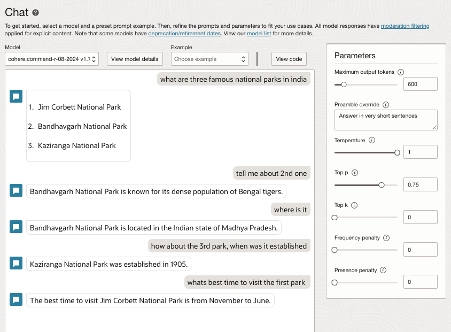

##  JSON format

### note this is only availble for 08-2024 models
### good habit its to specify JSON generation in preamble 

read restrictions here: https://docs.cohere.com/docs/structured-outputs-json#schema-constraints


In [ ]:
# change top the supported model
chat_detail.serving_mode = OnDemandServingMode(model_id="cohere.command-r-08-2024")
llm_chat_request.response_format = CohereResponseJsonFormat()
llm_chat_request.preamble_override = "Answer in json format"
llm_chat_request.message = "list 3 Latest novels from indian authors "

llm_chat_request.max_tokens = 500
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
print (llm_text)

  


Here we specify a simple JSON. note the scheme only allows for one entry.
so even thouhg we ask for multiple answer will be just one

In [ ]:
response_schema = {
            "type": "object",
            "required": ["title", "author", "publication_year"],
            "properties": {
                "title": {"type": "string"},
                "author": {"type": "string"},
                "publication_year": {"type": "integer"},
            },
        }

llm_chat_request.response_format = CohereResponseJsonFormat(schema = response_schema)
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
print (llm_text)


### nested schema with array

Here we allso for an array so the answer will be multiple entries
also see how we were able to break name into first & last name

In [ ]:
response_schema = {
            "type": "object",
            "required": ["authors"],
            "properties" : {
                "authors" : {
                        "type" : "array",
                        "items" : {
                                "type" : "object",
                                "required": ["title", "author", "publication_year"],
                                "properties": {
                                        "title": {"type": "string"},
                                        "author": {
                                                "type": "object",
                                                "required" : ["fname", "lname"],
                                                "properties" : {
                                                        "fname" : {"type":"string"},       
                                                        "lname" : {"type":"string"}
                                                }
                                        },
                                        "publication_year": {"type": "integer"}
                                }
                        }        
                }
            }
        }

llm_chat_request.response_format = CohereResponseJsonFormat(schema = response_schema)
llm_chat_request.message = "list three most popular novels from indian authors last 2022"
llm_response = llm_client.chat(chat_detail)
llm_text = llm_response.data.chat_response.text
print (llm_text)

### Exercise three
 * Create a program to
    * Create 2 stanza poem about a famous Indian personality
    * Ask llm extract set of entities
    * Specify the output schema with fixed fields

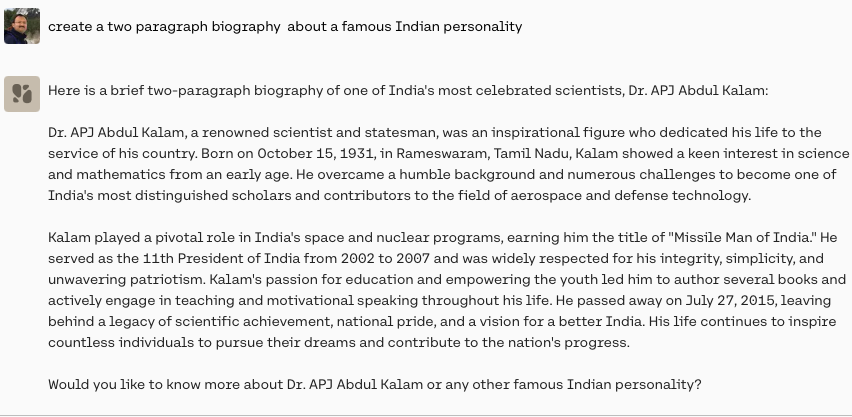
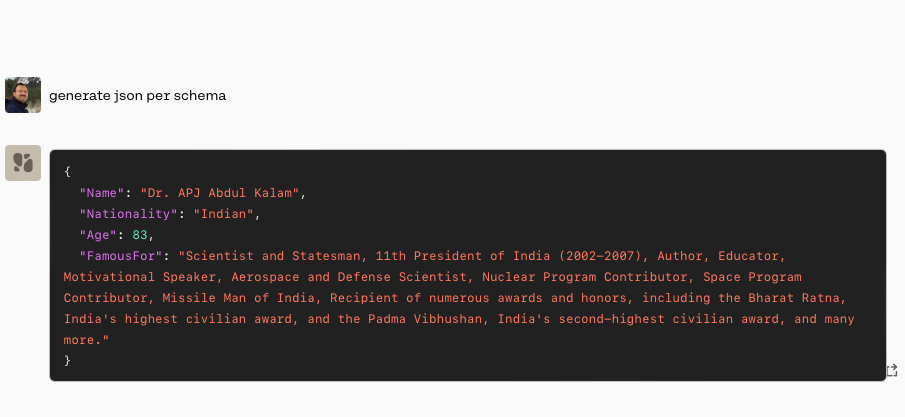

## Streaming response

OCI support SSE for streaming the response each token as its generated 

In [ ]:

#ask the question 
llm_chat_request.preamble_override = "Answer as a poem" 
llm_chat_request.message = "why is sky blue"
llm_chat_request.is_stream = True 
llm_chat_request.response_format = CohereResponseTextFormat()

# geerate response
llm_response = llm_client.chat(chat_detail)

# stream twh output
import json 
for event in llm_response.data.events():
    res = json.loads(event.data)
    if 'finishReason' in res.keys():
        print(f"\nFinish reason: {res['finishReason']}")
        break
    if 'text' in res:
        print(res['text'], end="", flush=True)
print("\n")

